In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input

In [10]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input

image_size = 299
batch_size = 1
valid_size = 1
# 학습 및 검증 데이터용 ImageDataGenerator 생성해 놓기 
train_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.20)

#검증데이터는 정규화 외에 따로 조정 없음 
valid_datagen = ImageDataGenerator(rescale=1./255., 
                                   validation_split = 0.20)

#flow_from_directory()는 앞서 배운 flow()와 비슷, 단 경로를 통채로 가져올 수 있음 
# seed 값이 같으므로 train subset과 validation subset이 중복될 일은 없다.
# batch_size = 32, shuffle=True이므로 랜덤하게 32개의 이미지를 디렉토리에서 골라서 보강하여 반환한다.
train_generator = train_datagen.flow_from_directory(directory = '/content/drive/My Drive/인공지능 학습관련/COVID_VS_NON-COVID/TRAIN', #저장 경로 
                                                    subset = 'training',   
                                                    batch_size = batch_size,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'binary',
                                                    target_size = (image_size,image_size))

valid_generator = valid_datagen.flow_from_directory(directory = '/content/drive/My Drive/인공지능 학습관련/COVID_VS_NON-COVID/TRAIN',
                                                    subset = 'validation',
                                                    batch_size = valid_size,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'binary',
                                                    target_size = (image_size,image_size))
print(train_generator.n)
print(valid_generator.n)


Found 5650 images belonging to 2 classes.
Found 1412 images belonging to 2 classes.
5650
1412


In [7]:
# Make model == feature model
feature_model = keras.applications.inception_resnet_v2.InceptionResNetV2(weights="imagenet", include_top=False)

219062272/219055592 [==============================] - 4s 0us/step


In [35]:
feature_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
________________________________________________________________________________

In [5]:
import numpy as np
from tqdm import tqdm

train_features = [] # 빈 리스트 생성 
train_Y = [] # 빈 리스트 생성 

for idx in tqdm(range(train_generator.n)): # 2785 

    x, y = train_generator.next() #next()를 활용하여 train_generator에 담겨진 [[입력픽셀],[라벨링]] 을 x와 y에 담아 준다.  
    train_Y.extend(y) #append()와 비슷한 기능, list에 appending 수행
    #   print(x.shape, y.shape) --> (32, 299, 299, 3), (32, 120)
    # feature_model : 이미 학습이 완료된 특징 추출기 (우리가 불러옴)
    # 학습데이터 x 를 활용해서 feature_model을 통과시켜 특징 추출.
    feature = feature_model.predict(x)
    #   print(feature.shape) --> (32,2048)
    train_features.extend(feature)

#array 전환 
train_features = np.array(train_features)
train_Y = np.array(train_Y)

print(train_features.shape) 
print(train_Y.shape) 

100%|██████████| 5650/5650 [1:32:15<00:00,  1.02it/s]


(5650, 8, 8, 1536)
(5650,)


In [38]:
train_Y

array([1., 1., 0., ..., 1., 1., 1.], dtype=float32)

In [6]:
valid_features = [] # 빈 리스트 생성 
valid_Y = [] # 빈 리스트 생성 
from tqdm import tqdm

for idx in tqdm(range(valid_generator.n)): ## valid_generator.n = 696 (검증데이터의 수)

    x, y = valid_generator.next() #next()를 활용하여 valid_generator에 담겨진 [[입력픽셀],[라벨링]] 을 x와 y에 담아 준다.   
    valid_Y.extend(y) #append()와 비슷한 기능, list에 appending 수행
  
    # feature_model : 이미 학습이 완료된 특징 추출기 (우리가 불러옴)
    # 학습데이터 x 를 활용해서 feature_model을 통과시켜 특징 추출.
    feature = feature_model.predict(x)
    valid_features.extend(feature)

#array 전환 
valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)

print(valid_features.shape)
print(valid_Y.shape)

100%|██████████| 1412/1412 [21:23<00:00,  1.10it/s]


(1412, 8, 8, 1536)
(1412,)


In [13]:
# Make Classifier Model
def create_model():
    input = Input(shape=feature_model.output.shape[1:])


    x = BatchNormalization()(input)

    x = GlobalAveragePooling2D()(x)

    x = Dense(256, activation='relu')(x)

    x = tf.keras.layers.Dropout(0.6)(x)

    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input, outputs=predictions)

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    
    return model


# 모델 객체를 만듬
model = create_model()

checkpoint_path = '/content/drive/My Drive/인공지능 학습관련/covid19_detection_model_2class'

cp = ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=True,
                                save_best_only=True,
                                monitor='val_accuracy',
                                verbose=1)
                    
es = EarlyStopping(patience=10, verbose=1)
history = model.fit(train_features, train_Y, 
                    validation_data=(valid_features, valid_Y),
                    epochs = 200,
                    batch_size = 32,
                    callbacks=[es,cp])
model.summary()

Epoch 1/200
177/177 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.9765
Epoch 00001: val_accuracy improved from -inf to 0.99009, saving model to /content/drive/My Drive/인공지능 학습관련/covid19_detection_model_2class
177/177 [==============================] - 4s 23ms/step - loss: 0.0696 - accuracy: 0.9765 - val_loss: 0.0264 - val_accuracy: 0.9901
Epoch 2/200
175/177 [============================>.] - ETA: 0s - loss: 0.0361 - accuracy: 0.9893
Epoch 00002: val_accuracy did not improve from 0.99009
177/177 [==============================] - 4s 21ms/step - loss: 0.0364 - accuracy: 0.9890 - val_loss: 0.0245 - val_accuracy: 0.9880
Epoch 3/200
176/177 [============================>.] - ETA: 0s - loss: 0.0255 - accuracy: 0.9927
Epoch 00003: val_accuracy improved from 0.99009 to 0.99363, saving model to /content/drive/My Drive/인공지능 학습관련/covid19_detection_model_2class
177/177 [==============================] - 4s 21ms/step - loss: 0.0256 - accuracy

In [60]:
model.save('/content/drive/My Drive/인공지능 학습관련/covid_model_2class.h5')

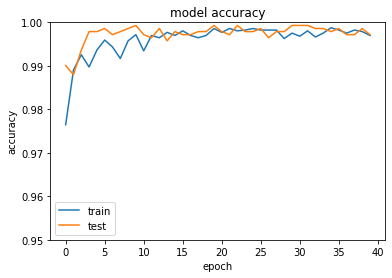

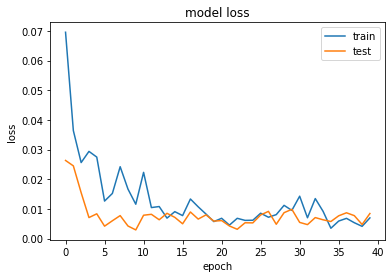

In [25]:
# 모델 acc/loss 그래프

## summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.ylim((0.95,1))
plt.show()
## summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

plt.show()

In [27]:
model2 = create_model()
# 가중치 로드

model2.load_weights(checkpoint_path)

# 모델 평가
print(model2.evaluate(valid_features, valid_Y))
model2.summary()

45/45 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 0.9993
[0.002943323692306876, 0.9992917776107788]
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, None, None, 1536) 0         
_________________________________________________________________
batch_normalization_208 (Bat (None, None, None, 1536)  6144      
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1536)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               393472    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 

In [59]:
model2.save('/content/drive/My Drive/인공지능 학습관련/covid_model_best_2class.h5')

In [2]:
# last_conv_layer_model == feature_model
# 이미지 전처리
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

#  히트맵 생성
def make_gradcam_heatmap(img_path, classifier_model, last_conv_layer_model):
    img_size = (299, 299)
    # input배열을 inception_resnet_v2에 맞게 전처리
    img_array = preprocess_input(get_img_array(img_path, size=img_size))


    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    # 보정 -- 이미지의 최 외곽부 모두 0
    a = np.vstack((np.zeros(heatmap[:2].shape),heatmap[2:-1]))
    a = np.vstack((a[:-1],np.zeros(heatmap[-1:].shape)))
    for i in a:
        i[0] = 0
        i[-1] = 0
    heatmap = a

    return heatmap

# 감마보정
# gamma correction 
def gamma_correction(img, c=1, g=2.2): 
    out = img.copy() 
    out /= 255. 
    out = (1/c * out) ** (1/g) 
    out *= 255 
    out = out.astype(np.uint8) 
    return out 

# CAM이미지 + 원본
def show_CAM(img_path, heatmap, prediction):
    # We load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("Reds")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # gamma correction
    jet_heatmap = gamma_correction(jet_heatmap, g=2.2)

    # Superimpose the heatmap on original image
    # NORMAL이면 원본이미지만 반환
    if prediction =='non-COVID':
        superimposed_img = img
    else:
        superimposed_img = jet_heatmap *0.5 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img


In [12]:
# 테스트 파일 가져오기
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_directory(directory = '/content/drive/My Drive/인공지능 학습관련/COVID_VS_NON-COVID/TEST',
                                                    subset = 'training',   
                                                    batch_size = batch_size,
                                                    seed = 126,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

print(test_generator.n)

Found 1288 images belonging to 2 classes.
1288


In [6]:
model2 = load_model('/content/drive/My Drive/인공지능 학습관련/covid_model_best_2class.h5')

['gray', 'blue']
[2.980232238769531e-07, 0.9999997019767761]


ValueError: ignored

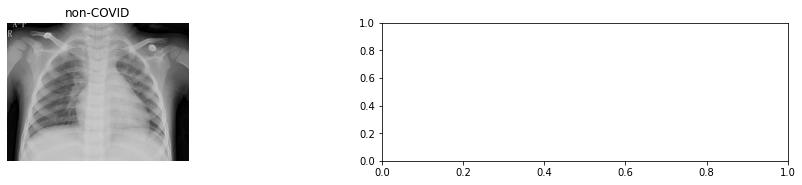

In [26]:
import random
import cv2

predictY = []
realY = []
ratio = []
iter = 10
model = model2

unique_sorted_Y = ['COVID','non-COVID']
plt.figure(figsize=(16,iter*3))


for i in range(iter): 
    image_path = random.choice(test_generator.filepaths)
    
    #출력 범위 설정 
    plt.subplot(iter,2,i*2+1)

    #검증데이터 출력 
    plt.imshow(plt.imread(image_path))

    # split('/')를 통해 나눠진 부분 중 3번째 획득
    real_y = image_path.split('/')[-2]
    # real_y → bluetick 출력 
    #타이틀 출력 
    plt.title(real_y)
    plt.axis('off')
    #unique_sorted_Y 에 저장된 값을 바탕으로 real_y의 위치 값 할당 
    idx = unique_sorted_Y.index(real_y)
    # idx → ex) 81, ...  

    #예측값 표기
    plt.subplot(iter,2,i * 2+2)
    img_size = (299, 299)
    # 이미지 불러오기 및 이미지 크기 조정
    img = keras.preprocessing.image.load_img(image_path, target_size=img_size)
    # 이미지를 array로 변경
    img = keras.preprocessing.image.img_to_array(img)
    # 각 픽셀값을 0과 1사이의 값으로 조정
    img = img / 255.0
    # 모델의 인풋 타입에 맞게 차원을 하나 늘림
    img = np.expand_dims(img, axis=0)

    #img를 Inception V3의 특징 추출기 feature_model을 활용하여 특징 벡터를 생성. 
    feature_vector = feature_model.predict(img)

    # 앞서 생성한 model 분류기를 통해 예측 수행
    prediction = model.predict(feature_vector)[0]
    
    color = ['gray'] * 2
    if prediction <= 0.5:
        predict = 0
        color[0] = 'blue'
    else:
        predict = 1
        color[1] = 'blue'

    print(color)

    covid_ratio = float(1-prediction)
    non_ration = float(prediction)

    ratio.append(covid_ratio)
    ratio.append(non_ration)

    print(ratio)

    #가로 막대 그리기 
    plt.barh(range(2), ratio * 100, color = color)
    plt.yticks(range(2), unique_sorted_Y)

    # print(labels[0], realY[0])
    predictY.append(labels[0])
    realY.append(real_y)
    print(labels[0],real_y)
    plt.show()

In [53]:
ratio

[0.0, 1.0]

In [42]:
# 글자만.
import random
import cv2

predictY = []
realY = []
iter = 100

unique_sorted_Y = ['COVID','non-COVID']

for i in range(iter): 
    image_path = random.choice(test_generator.filepaths)
    # split('/')를 통해 나눠진 부분 중 3번째 획득
    real_y = image_path.split('/')[-2]
    # real_y → bluetick 출력 

    img_size = (299, 299)
    # 이미지 불러오기 및 이미지 크기 조정
    img = keras.preprocessing.image.load_img(image_path, target_size=img_size)
    # 이미지를 array로 변경
    img = keras.preprocessing.image.img_to_array(img)

    # 각 픽셀값을 0과 1사이의 값으로 조정
    img = img / 255.0
    # 모델의 인풋 타입에 맞게 차원을 하나 늘림
    img = np.expand_dims(img, axis=0)


    #img를 Inception V3의 특징 추출기 feature_model을 활용하여 특징 벡터를 생성. 
    feature_vector = feature_model.predict(img)

    # 앞서 생성한 model 분류기를 통해 예측 수행
    prediction = model.predict(feature_vector)[0]
    # print(prediction)
    if prediction <= 0.5:
        predict = 0
    else:
        predict = 1
    #labels에 저장 
    label = unique_sorted_Y[predict] 
    
    # print(labels[0], realY[0])
    predictY.append(label)
    realY.append(real_y)
    print(label,real_y)

non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID COVID
non-COVID non-COVID
COVID COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
COVID COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
COVID COVID
non-COVID non-COVID
COVID COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-COVID
non-COVID non-CO

Confusion matrix, without normalization
[[10  0]
 [ 1 89]]


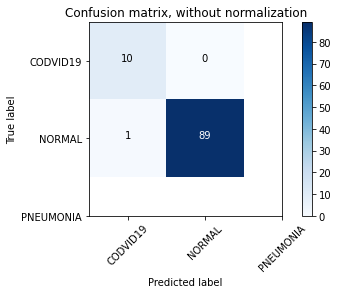

In [43]:
import itertools
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(predictY, realY)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plt.figure()
plot_confusion_matrix(cm, classes=['CODVID19', 'NORMAL', 'PNEUMONIA'], title='Confusion matrix, without normalization')

In [ ]:
import random
import cv2

iter = 1
# model = model2

unique_sorted_Y = ['COVID','NORMAL','PNEUMONIA']
plt.figure(figsize=(16,iter*3))



for i in range(iter): 
    image_path = '/content/pneumonia3.jpg'
    
    #출력 범위 설정 
    plt.subplot(iter,2,i*2+1)

    #검증데이터 출력 
    plt.imshow(plt.imread(image_path))

    #예측값 표기
    plt.subplot(iter,2,i * 2+2)
    img_size = (299, 299)
    # 이미지 불러오기 및 이미지 크기 조정
    img = keras.preprocessing.image.load_img(image_path, target_size=img_size)
    # 이미지를 array로 변경
    img = keras.preprocessing.image.img_to_array(img)
    # 각 픽셀값을 0과 1사이의 값으로 조정
    img = img / 255.0
    # 모델의 인풋 타입에 맞게 차원을 하나 늘림
    img = np.expand_dims(img, axis=0)
    print(img.shape)

    #img를 Inception V3의 특징 추출기 feature_model을 활용하여 특징 벡터를 생성. 
    feature_vector = feature_model.predict(img)

    # 앞서 생성한 model 분류기를 통해 예측 수행
    prediction = model.predict(feature_vector)[0]

    #가장 높은 확률의 예측값을 5개 선출 
    #[::-1] Extended Slices 기법으로 내림차순으로 변경, [:5] 그 중 top 5개
    top_3_predict = prediction.argsort()[::-1][:3]
    #labels에 저장 
    labels = [unique_sorted_Y[index] for index in top_3_predict]
    color = ['gray'] * 3
    #예측 수행한 Top 5 값에 대하여 'blue' 으로 변경
    if idx in top_3_predict:
        color[top_3_predict.tolist().index(idx)] = 'blue'
    color = color[::-1]
    #가로 막대 그리기 
    plt.barh(range(3), prediction[top_3_predict][::-1] * 100, color = color)
    plt.yticks(range(3), labels[::-1])

    print(labels[0])

    

